In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from IPython.display import clear_output
import datetime
import os
from tqdm import tqdm
import time

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold


import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torchvision.models import VGG16_Weights
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
from transformers import pipeline


print('Is CUDA available ?', torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in vgg16.parameters():
    param.requires_grad = False

C:\Users\User\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Is CUDA available ? True


In [2]:
validation_rate = 0.1
json_data_training_images_total = pd.read_json("train_data.json")['img_filepath']
train_num = int(json_data_training_images_total.shape[0] * (1 - validation_rate))

json_data_validation_images = json_data_training_images_total.iloc[train_num: ]
json_data_training_images = json_data_training_images_total.iloc[: train_num]

json_data_testing_images = pd.read_json("test_data.json")['img_filepath']
labels = pd.read_csv("train_label.csv")
labels.set_index('Pid', inplace = True)

train_labels = labels.iloc[: train_num]
validation_labels = labels.iloc[train_num: ]

In [3]:
class LoadDataClass(Dataset):
    def __init__(self, dirpath, labels_data, train, transform=None):
        """ 
        Initialize dataset
        dirpath is a pandas object
        labels_data is a pandas dataframe
        """
        self.dirpath = dirpath
        self.labels_data = labels_data
        self.train = train
        self.filepaths = []
        self.labels = []
        self.transform = transform
        
        for fp in self.dirpath:
            self.filepaths.append(fp)
            image = fp.split('/')[2]
            index = int(image[0: image.find('.')])
            if train:
                self.labels.append(self.labels_data.loc[index].values[0])


    def __getitem__(self, index):
        """ Get a sample from the dataset """
                
        fp = self.filepaths[index]
        image = Image.open(fp)
        image = image.convert('RGB')

        if self.train:
            label = self.labels[index]
        else:
            label = 'Test data'

        if self.transform is not None:
            image = self.transform(image)
        image.unsqueeze(0)
        
        return image, label
    
    def __len__(self):
        """ Get total number of samples in the dataset """
        return len(self.filepaths)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

trainset = LoadDataClass(
    dirpath = json_data_training_images,
    labels_data = train_labels,
    train = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

validationset = LoadDataClass(
    dirpath = json_data_validation_images,
    labels_data = validation_labels,
    train = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

testset = LoadDataClass(
    dirpath = json_data_testing_images,
    labels_data = None,
    train = False,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)


trainset_total = LoadDataClass(
    dirpath = json_data_training_images_total,
    labels_data = labels,
    train = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

#transforms.RandomHorizontalFlip(),
#transforms.RandomRotation((-30, 30), expand=False),

trainset_total_noshuffle = LoadDataClass(
    dirpath = json_data_training_images_total,
    labels_data = None,
    train = False,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

In [5]:
def imageshow(sample):
    """ show the image of a sample """
    image = sample[0]
    label = sample[1]
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    # reshape the img from (3, 32, 32) to (32, 32, 3)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.title(label)
    plt.show()

In [6]:
dataloader = {
    'train': DataLoader(trainset, batch_size = 32, shuffle = True),
    'validation': DataLoader(validationset, shuffle = False),
    'test': DataLoader(testset, shuffle = False),
    'total_train': DataLoader(trainset_total, batch_size = 32, shuffle = True),
    'total_train_noshuffle': DataLoader(trainset_total_noshuffle, shuffle = False),
}

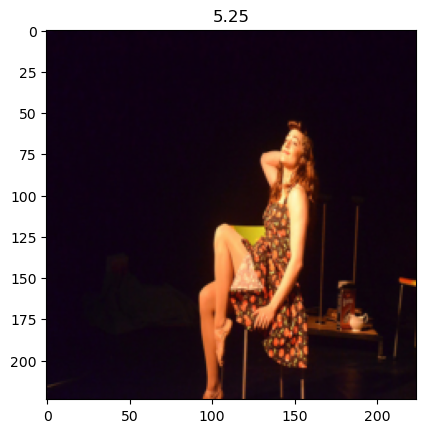

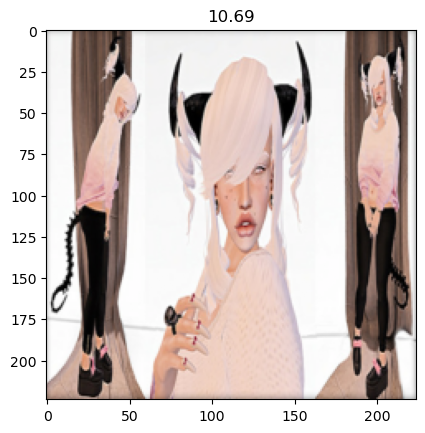

In [7]:
for i in range(1):
    sample = dataloader['train'].dataset[random.randint(0, len(dataloader['train']))]
    print((dataloader['train']))
    imageshow(sample)
for i in range(1):
    index = random.randint(0, len(dataloader['validation']))
    sample = dataloader['validation'].dataset[index]
    imageshow(sample)

In [8]:
class VGG16Predictor(nn.Module):
    def __init__(self, vgg16_weights = None):
        super(VGG16Predictor, self).__init__()
        # 3 x 224 x 224
        #self.feats = vgg16(weights = vgg16_weights).features
        self.feats = vgg16.features

        # 512 x 7 x 7
        self.extracter = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1), # 512 x 7 x 7
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride = 1),
            nn.Conv2d(256, 64, kernel_size=3, padding=1), # 64 x 7 x 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride = 1),
            nn.Conv2d(64, 8, kernel_size=3, padding=1), # 8 x 7 x 7
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride = 1),
            nn.Flatten(),
            nn.Linear(8 * 7 * 7, 64),
            nn.ReLU(), 
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 6)
        )
        
        self.predictor = nn.Sequential(
            nn.ReLU(),
            nn.Linear(6, 1)
        )

    def forward(self, x):
        feats = self.feats(x)
        extracter = self.extracter(feats)
        predictor = self.predictor(extracter)
        return predictor
    
    def extract(self, x):
        return self.extracter(self.feats(x))

In [9]:
def test(model, criterion, dataloader, validation = False):
    model.eval()

    total_loss = 0
    correct = 0
    pred = []
    real = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y_out = model(x)
            pred.append(y_out.cpu().detach().numpy()[0][0])
            if validation:
                real.append(y.numpy()[0])
            
    if validation == True:
        #pred = np.array(pred).reshape(-1, 1)
        #real = np.array(real).reshape(-1, 1)
        total_loss = mean_absolute_error(real, pred)
    else:
        total_loss = 0
    return total_loss, pred

In [10]:
def train(model, optimizer, criterion, train_data, validation_data, validation = True, epochs = 20):

    loss_trajectory = []
    train_loss_trajectory = []
    for epoch in range(epochs):
        model.train()

        epoch_loss = 0
        count = 0
        for (x, y) in tqdm(train_data):
            count += 1
            x, y = x.to(device), y.to(device)
            y = y.float()
            
            optimizer.zero_grad()
            y_out = model(x).squeeze()  
            loss = criterion(y_out, y)
            loss.backward()
            optimizer.step() 
            epoch_loss += loss.cpu().detach().numpy() 
        
        train_loss_trajectory.append(epoch_loss / count)
        if validation:
            validation_loss, _ = test(model, criterion, validation_data, True)
            loss_trajectory.append(validation_loss)
            clear_output(wait = True)
            plt.figure(figsize = (12, 8))
            plt.subplot(211)
            plt.grid(True)
            plt.plot([i for i in range(1, len(loss_trajectory) + 1)], loss_trajectory)
            plt.title("Validation")
            plt.subplot(212)
            plt.grid(True)
            plt.plot([i for i in range(1, len(train_loss_trajectory) + 1)], train_loss_trajectory)
            plt.title("Train")
            plt.show()
            print(f"Epoch [{epoch + 1} / {epochs}] Validation Loss: {validation_loss}")
        else:
            clear_output(wait = True)
            print(f"Epoch [{epoch + 1} / {epochs}]")
    
    if validation:
        return loss_trajectory, model
    else:
        return None, model

In [ ]:
# validation 

#epochs = 20
#vgg16predictor = VGG16Predictor()
#vgg16predictor.to(device)
#optimizer = optim.Adam(vgg16predictor.parameters(), lr = 1*1e-4)
#criterion = nn.L1Loss()
#print(vgg16predictor)
#loss_trajectory, model = train(vgg16predictor, optimizer, criterion, dataloader['train'], dataloader['validation'], epochs = epochs)

In [11]:
epochs = 1

vgg16predictor = VGG16Predictor()
vgg16predictor.to(device)

optimizer = optim.Adam(vgg16predictor.parameters(), lr = 1e-4)
criterion = nn.L1Loss()
print(vgg16predictor)

loss_trajectory, vgg16predictor = train(vgg16predictor, optimizer, criterion, dataloader['total_train'], dataloader['validation'], validation = False, epochs = epochs)

Epoch [60 / 60]


In [12]:
date = time.ctime(time.time())[:10].replace(' ', '')

_, test_prediction = test(vgg16predictor, criterion, dataloader['test'])
testpid = pd.read_json("test_data.json")['Pid']
testpid = pd.DataFrame(testpid)
testpid['label'] = test_prediction
testpid.to_csv(f"Image_Only_{date}_test_epochs{epochs}.csv", index = False)

_, train_prediction = test(vgg16predictor, criterion, dataloader['total_train_noshuffle'])
trainpid = pd.read_json("train_data.json")['Pid']
trainpid = pd.DataFrame(trainpid)
trainpid['label'] = train_prediction
trainpid.to_csv(f"Image_Only_{date}_train_epochs{epochs}.csv", index = False)

torch.save(vgg16predictor.state_dict(), f"ImageExtractor_{date}_{epochs}.pt")

In [ ]:

#vgg16predictor = VGG16Predictor()
#vgg16predictor.load_state_dict(torch.load(f"ImageExtractor_{date}.pt"))
#vgg16predictor.eval()
#vgg16predictor.to(device)


In [13]:
def extract(model, dataloader):
    model.eval()

    extract = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y_out = model.extract(x)
            extract.append(y_out.cpu().detach().numpy()[0])
            
    
    return extract

In [14]:
train_extract = pd.DataFrame(extract(vgg16predictor, dataloader['total_train_noshuffle']))
test_extract = pd.DataFrame(extract(vgg16predictor, dataloader['test']))

In [15]:
train_extract.to_csv(f"Train_ImageExtract_{date}_{epochs}.csv", index = False)
test_extract.to_csv(f"Test_ImageExtract_{date}_{epochs}.csv", index = False)

In [11]:
def K_fold(X, Y, folds = 5):
    # X = json_data_training_images
    # Y = train_labels
    
    kf = KFold(n_splits = folds)
    kf.get_n_splits(X)
    LOSS_TRAJECTORY = []
    for train_index, val_index in kf.split(X):
        trainset = LoadDataClass(
            dirpath = X.iloc[train_index],
            labels_data = Y.iloc[train_index],
            train = True,
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
            )

        validationset = LoadDataClass(
            dirpath = X.iloc[val_index],
            labels_data = Y.iloc[val_index],
            train = True,
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
            )
        
        dataloader = {
            'train': DataLoader(trainset, batch_size = 32, shuffle = True),
            'validation': DataLoader(validationset, shuffle = False)
        }

        vgg16predictor = VGG16Predictor()
        vgg16predictor.to(device)
        optimizer = optim.Adam(vgg16predictor.parameters(), lr = 1*1e-4)
        criterion = nn.L1Loss()
        
        LOSS_TRAJECTORY.append(train(vgg16predictor, optimizer, criterion, dataloader['train'], dataloader['validation'], epochs = 20)[0])
        
    return LOSS_TRAJECTORY
        

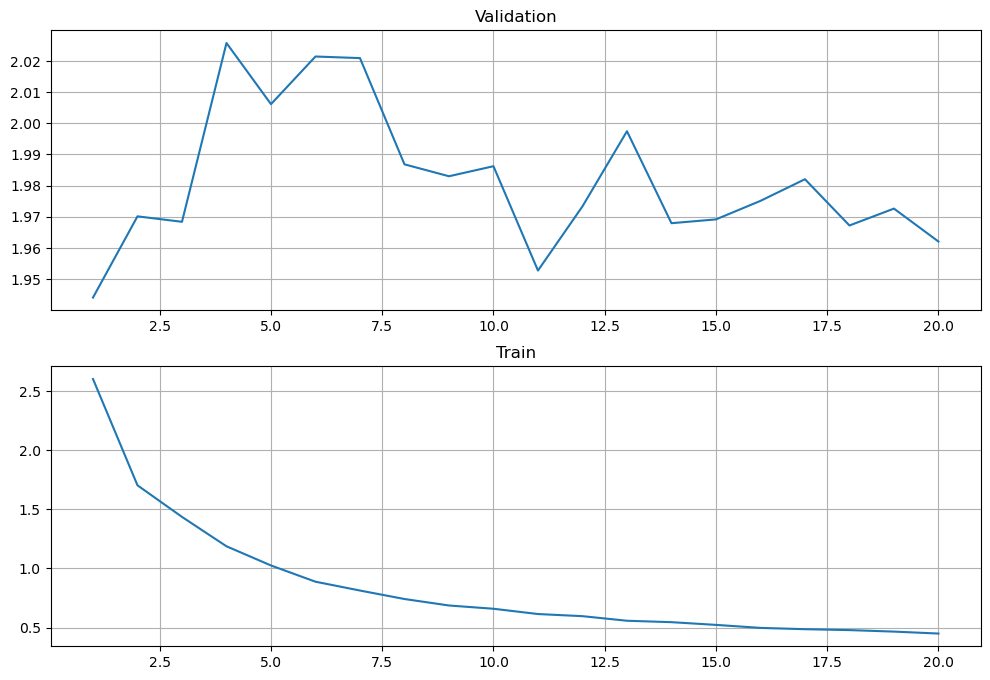

Epoch [20 / 20] Validation Loss: 1.9620655776942217


In [12]:
trajectories = K_fold(json_data_training_images, train_labels)
trajectories_dict = defaultdict(list)
for i in range(len(trajectories[0])):
    for j in range(len(trajectories)):
        trajectories_dict[f"epoch{i}"].append(trajectories[j][i])
        trajectories_dict[f"epoch{i}"] = sorted(trajectories_dict[f"epoch{i}"])

trajectories_dict = dict(trajectories_dict)
trajectories_pd = pd.DataFrame(trajectories_dict)
trajectories_pd.to_csv("5-folds.csv")